In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
from numba import njit, prange
from pyproj import Transformer
from geodatasets import get_path
import contextily as ctx
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sqlalchemy import create_engine
import psycopg2
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from shapely.geometry import box
from skimage.draw import line_nd

import warnings
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*DataFrame.swapaxes.*"
)

In [4]:
DATA_PATH = '/home/lennartz/data/nypd-collision/Motor_Vehicle_Collisions_-_Crashes_20250627.csv'

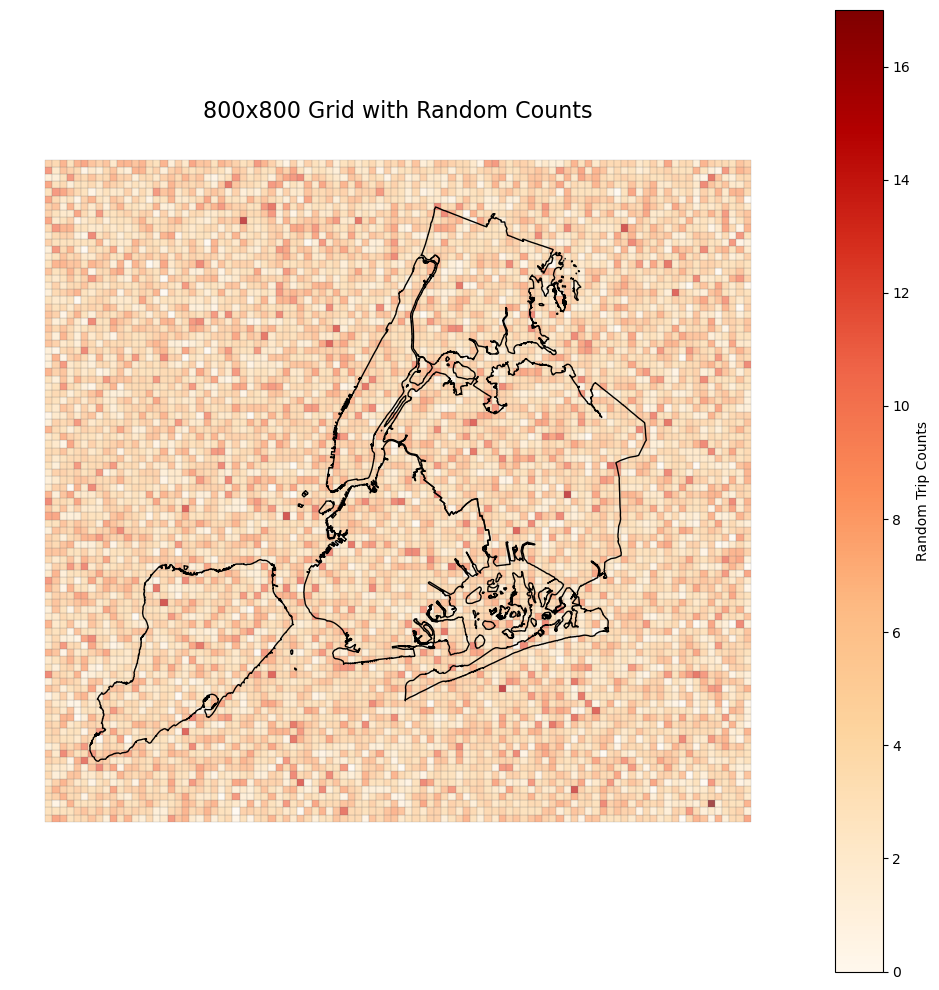

In [5]:
# Define bounding box for the study area in lon/lat
lon_min, lat_min, lon_max, lat_max = -74.3, 40.45, -73.6, 40.95

# Create GeoDataFrame for bounding box and reproject to Web Mercator
bbox_df = pd.DataFrame({'geometry': [box(lon_min, lat_min, lon_max, lat_max)]})
bbox = gpd.GeoDataFrame(bbox_df, geometry='geometry', crs="EPSG:4326")
bbox = bbox.to_crs(epsg=3857)

# Determine grid bounds and cell size
minx, miny, maxx, maxy = bbox.total_bounds
cell_size = 800  # meters

# Generate 800x800 grid polygons
cols = np.arange(minx, maxx + cell_size, cell_size)
rows = np.arange(miny, maxy + cell_size, cell_size)
polygons = [box(x, y, x + cell_size, y + cell_size) for x in cols[:-1] for y in rows[:-1]]

# Create GeoDataFrame for the grid
grid_df = pd.DataFrame({'geometry': polygons})
grid = gpd.GeoDataFrame(grid_df, geometry='geometry', crs="EPSG:3857")

# Assign random counts for demonstration
np.random.seed(42)
grid['counts'] = np.random.poisson(lam=5, size=len(grid))

# Load NYC borough boundaries for context
nybb = gpd.read_file(get_path("nybb")).to_crs(epsg=3857)

# Plot the grid and random counts
fig, ax = plt.subplots(figsize=(10, 10))
nybb.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
grid.plot(
    column='counts',
    ax=ax,
    cmap='OrRd',
    edgecolor='grey',
    linewidth=0.2,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Random Trip Counts"}
)
ax.set_title("800x800 Grid with Random Counts", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()


# Does a trip pass a dangerous area at a dangerous time?
For this we need to normalize accident counts by trips taken. We transform the map and time to a 3D grid. A trip is a line through this, and we can use Bresenham to find voxels (read places at some time) it passed through. This is conveniently implemented in scikit image lineNd (limitations are num_voxels).
1. try it
2. multiprocess it for our gazillion trips

In [ ]:
lon_min, lat_min = -74.3, 40.45
lon_max, lat_max = -73.6, 40.95

# Create and reproject
bbox = gpd.GeoSeries(
    [box(lon_min, lat_min, lon_max, lat_max)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

minx, miny, maxx, maxy = bbox.total_bounds 

cell_x, cell_y = 800.0, 800.0      # metres
cell_t = 6.0                       # hours
time_max = 365 * 24                # hours
ref = pd.Timestamp("2023-01-01 00:00:00")

Nx = math.ceil((maxx - minx) / cell_x) # number of cells in x-direction
Ny = math.ceil((maxy - miny) / cell_y) # number of cells in y-direction
Nt = math.ceil(time_max / cell_t)      # number of time steps / steps in z direction (days (365) * 24 / time chunk size (6))

engine = create_engine(
    "postgresql+psycopg2://lennartz@localhost:5432/citibike2023"
)

transformer = Transformer.from_crs(
    "EPSG:4326", "EPSG:3857", always_xy=True
)


In [ ]:
def to_grid_indices(
    lon, lat, t,
    minx=minx, miny=miny,
    cell_x=cell_x, cell_y=cell_y, cell_t=cell_t,
    transformer=transformer    
):
    """
    Map (lon, lat, t) to integer grid indices (ix, iy, it).
    Can be negative or exceed (Nx-1, Ny-1, Nt-1).
    """

    # 1. Project lon/lat → Web Mercator (metres)
    x, y = transformer.transform(lon, lat)              

    # 2. Offset and floor-divide
    ix = math.floor((x - minx) / cell_x)
    iy = math.floor((y - miny) / cell_y)
    it = math.floor((t - 0.0)   / cell_t)

    return ix, iy, it


def map_to_grid_indices(args):
    """Helper for parallel grid mapping."""
    lon, lat, t = args
    return to_grid_indices(lon, lat, t)


def parallel_map_grid(df, cols, new_cols, chunksize=None):
    """
    Parallel map of (lon, lat, t) -> (ix, iy, it)
    cols: list of source columns [lon, lat, t]
    new_cols: list of target columns [ix, iy, it]
    """
    n_workers = cpu_count()
    # Prepare arguments
    args = list(zip(df[cols[0]], df[cols[1]], df[cols[2]]))
    if chunksize is None:
        chunksize = max(1, len(args) // (n_workers * 4))
    
    with Pool(n_workers) as pool:
        results = pool.map(map_to_grid_indices, args, chunksize=chunksize)
    
    # Unzip results and assign back to DataFrame
    ix, iy, it = zip(*results)
    df[new_cols[0]] = ix
    df[new_cols[1]] = iy
    df[new_cols[2]] = it
    return df


def trip_rasterization(
    df_chunk,
    Nt, Ny, Nx,
):
    """
    Given a DataFrame chunk, map each ray into a local 3D count array.
    """
    local = np.zeros((Nt, Ny, Nx), dtype=np.uint32)
    for _, row in df_chunk.iterrows():
        start = (int(row['startt']), int(row['starty']), int(row['startx']))
        stop = (int(row['endt']),  int(row['endy']),  int(row['endx']))
        zz, yy, xx = line_nd(start, stop)
        local[zz, yy, xx] += 1
    return local


def parallel_trip_rasterization(df, Nt, Ny, Nx):
    """
    Parallel processing of DataFrame in chunks for ray rasterization.
    """
    num_workers = cpu_count()
    chunks = np.array_split(df, num_workers)

    # Prepare argument tuples for each chunk
    args = [(chunk, Nt, Ny, Nx) for chunk in chunks]

    with Pool(num_workers) as pool:
        partial_counts = pool.starmap(trip_rasterization, args)

    # Combine partial results
    global_counts = np.sum(partial_counts, axis=0).astype(np.uint32)
    return global_counts


def filter_inside(indices, shape):
    """
    Filter a list of (ix,iy,it) to only those within
    0 ≤ ix < shape[2], 0 ≤ iy < shape[1], 0 ≤ it < shape[0].
    """
    Nt, Ny, Nx = shape
    inside = []
    for ix, iy, it in indices:
        if (0 <= ix < Nx and
            0 <= iy < Ny and
            0 <= it < Nt):
            inside.append((ix, iy, it))
    return inside

In [ ]:
# 1. Connect once
conn = psycopg2.connect(dbname="citibike2023", user="lennartz", host="localhost")

# 2. Use a regular (unnamed) cursor to get the row count
with conn.cursor() as cnt_cur:
    cnt_cur.execute("""
      SELECT COUNT(*) FROM public.citibike_trips
      WHERE start_latitude  IS NOT NULL
        AND start_longitude IS NOT NULL
        AND end_latitude    IS NOT NULL
        AND end_longitude   IS NOT NULL;
    """)
    total_rows = cnt_cur.fetchone()[0]

batch_size    = 500_000
total_batches = math.ceil(total_rows / batch_size)

cur = conn.cursor(name="batch_cursor")  # server-side cursor
sample_sql = f"""
  SELECT start_latitude, start_longitude, started_at,
         end_latitude,   end_longitude,   ended_at
  FROM public.citibike_trips
  WHERE start_latitude  IS NOT NULL
    AND start_longitude IS NOT NULL
    AND end_latitude    IS NOT NULL
    AND end_longitude   IS NOT NULL;
"""

counts_list = []

# Execute and fetch in batches with progress bar
cur.execute(sample_sql)
with tqdm(total=total_batches, desc="Fetching batches") as pbar:
    while True:
        batch = cur.fetchmany(batch_size)
        if not batch:
            break
        df = pd.DataFrame(batch, columns=[
            "start_latitude", "start_longitude", "started_at",
            "end_latitude", "end_longitude", "ended_at"
        ])
        # Compute hours since the reference
        df["started_at_hours"] = (df["started_at"] - ref) / pd.Timedelta(hours=1)
        df["ended_at_hours"] = (df["ended_at"] - ref) / pd.Timedelta(hours=1)

        # 2. Time grid mapping in parallel
        df = parallel_map_grid(
            df,
            cols=["start_longitude", "start_latitude", "started_at_hours"],
            new_cols=["startx", "starty", "startt"],
        )
        df = parallel_map_grid(
            df,
            cols=["end_longitude", "end_latitude", "ended_at_hours"],
            new_cols=["endx", "endy", "endt"],
        )

        # filter data thats out of grid

        # 1. Build boolean masks for each set of indices
        mask_start = (
            (df["startx"]  >= 0) & (df["startx"]  < Nx) &
            (df["starty"]  >= 0) & (df["starty"]  < Ny) &
            (df["startt"]  >= 0) & (df["startt"]  < Nt)
        )
        mask_end   = (
            (df["endx"]    >= 0) & (df["endx"]    < Nx) &
            (df["endy"]    >= 0) & (df["endy"]    < Ny) &
            (df["endt"]    >= 0) & (df["endt"]    < Nt)
        )

        # 2. Keep only rows where both start AND end indices are valid
        valid_mask = mask_start & mask_end
        df   = df[valid_mask].reset_index(drop=True)

        global_counts = parallel_trip_rasterization(
            df,
            Nt=Nt, Ny=Ny, Nx=Nx
        )
        # Sum partial grids
        # counts = np.sum(partial_counts, axis=0)
        counts_list.append(global_counts)
        pbar.update(1)

cur.close()
conn.close()


Fetching batches: 9it [02:27, 16.42s/it]                       


KeyboardInterrupt: 

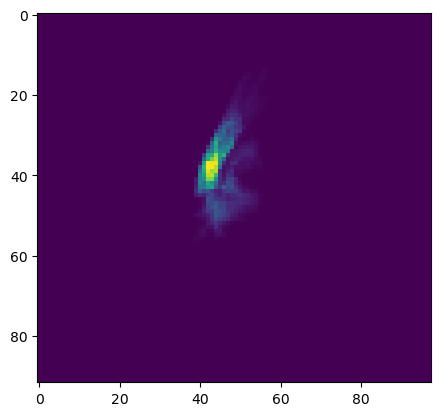

In [99]:
counts_time_flattened = np.stack([c.sum(0) for c in counts_list], axis=0).sum(0)
plt.imshow(np.flipud(counts_time_flattened))

In [16]:
df

,start_latitude,start_longitude,started_at,end_latitude,end_longitude,ended_at
0,40.729387,-73.977724,2023-02-05 13:12:35.909,40.729039,-73.994046,2023-02-05 13:20:17.027
1,40.746920,-74.004519,2023-02-23 17:58:17.280,40.729039,-73.994046,2023-02-23 18:15:31.320
2,40.664995,-73.976304,2023-02-11 14:51:13.769,40.665147,-73.976376,2023-02-11 15:25:57.210
3,40.732219,-73.981656,2023-02-26 13:27:25.020,40.723077,-73.985836,2023-02-26 13:34:09.993
4,40.721101,-73.991925,2023-02-17 14:06:53.133,40.723077,-73.985836,2023-02-17 14:10:34.017
...,...,...,...,...,...,...
499995,40.766741,-73.979069,2023-02-22 11:50:50.138,40.766741,-73.979069,2023-02-22 12:00:26.974
499996,40.712220,-74.010472,2023-02-21 21:33:36.386,40.686832,-73.979677,2023-02-21 22:21:50.537
499997,40.766442,-73.979602,2023-02-06 17:04:55.857,40.766741,-73.979069,2023-02-06 17:35:53.456
499998,40.809725,-73.953149,2023-02-05 19:05:47.462,40.809725,-73.953149,2023-02-05 20:13:11.288


In [ ]:
# Next steps:
# 1. transform to lon/lat/time grid
# 2. match to accident data

# lat-long-time to integer grid
For easy rasterisation:
1. transform lat/long/time intervals to integer grid with sizes we pick as parameters
2. write a function to transform any lat/long/time coordinate to this grid
3. write a function to filter points that are outside the grid. This filters voxel visits later that are outside our visualization

In [ ]:

# Use lat/lon box from plot above
lon_min, lat_min = -74.3, 40.45
lon_max, lat_max = -73.6, 40.95

# Create and reproject
bbox = gpd.GeoSeries(
    [box(lon_min, lat_min, lon_max, lat_max)],
    crs="EPSG:4326"
).to_crs(epsg=3857)

minx, miny, maxx, maxy = bbox.total_bounds 




cell_x, cell_y = 800.0, 800.0      # metres
cell_t = 6.0                       # hours
time_max = 365 * 24                # hours

Nx = math.ceil((maxx - minx) / cell_x) # number of cells in x-direction
Ny = math.ceil((maxy - miny) / cell_y) # number of cells in y-direction
Nt = math.ceil(time_max / cell_t)      # number of time steps / steps in z direction (days (365) * 24 / time chunk size (6))

print("Grid shape (time, rows, cols):", (Nt, Ny, Nx))


Grid shape (time, rows, cols): (1460, 92, 98)


In [ ]:

# Build a reusable transformer (always_xy=True -> lon,lat order)
transformer = Transformer.from_crs(
    "EPSG:4326", "EPSG:3857", always_xy=True
)

def to_grid_indices(lon, lat, t,
                    lon_min=lon_min, lat_min=lat_min,
                    minx=minx, miny=miny,
                    cell_x=cell_x, cell_y=cell_y, cell_t=cell_t):
    """
    Map (lon, lat, t) to integer grid indices (ix, iy, it).
    Can be negative or exceed (Nx-1, Ny-1, Nt-1).
    """
    # 1. Project lon/lat → Web Mercator (metres)
    x, y = transformer.transform(lon, lat)              

    # 2. Offset and floor-divide
    ix = math.floor((x - minx) / cell_x)
    iy = math.floor((y - miny) / cell_y)
    it = math.floor((t       - 0.0)   / cell_t)

    return ix, iy, it


def filter_inside(indices, shape):
    """
    Filter a list of (ix,iy,it) to only those within
    0 ≤ ix < shape[2], 0 ≤ iy < shape[1], 0 ≤ it < shape[0].
    """
    Nt, Ny, Nx = shape
    inside = []
    for ix, iy, it in indices:
        if (0 <= ix < Nx and
            0 <= iy < Ny and
            0 <= it < Nt):
            inside.append((ix, iy, it))
    return inside

In [ ]:
# Suppose grid_shape = (Nt, Ny, Nx) computed above
grid_shape = (Nt, Ny, Nx)

# A few test coordinates (lon, lat, t)
coords = [
    (-74.5, 40.5,  10),   # west of box → negative ix
    (-74.0, 40.6, 500),   # inside spatially, inside time
    (-73.5, 41.0, 8800)   # east/north/time too large → out of bounds
]

# Map to indices
indices = [to_grid_indices(lon, lat, t) for lon, lat, t in coords]

# Filter
valid = filter_inside(indices, grid_shape)

print("All indices:", indices)
print("Inside grid:", valid)


All indices: [(-28, 9, 1), (41, 27, 83), (111, 100, 1466)]
Inside grid: [(41, 27, 83)]


In [ ]:
import math

# Sanity check for 200×200 m grid
# Assumes `grid` is your GeoDataFrame in EPSG:3857

# 1. Compute bounding box from your grid
minx, miny, maxx, maxy = grid.total_bounds

# 2. Define your cell size
cell_size = 800.0  # meters

# 3. Compute expected rows and columns
n_cols = math.ceil((maxx - minx) / cell_size)
n_rows = math.ceil((maxy - miny) / cell_size)
expected_cells = int(n_cols * n_rows)

# 4. Compare to actual grid length
actual_cells = len(grid)

print(f"Bounding box: ({minx:.2f}, {miny:.2f}) to ({maxx:.2f}, {maxy:.2f})")
print(f"Cell size: {cell_size} m")
print(f"Expected # columns: {n_cols}, rows: {n_rows}")
print(f"Expected total cells: {expected_cells}")
print(f"Actual GeoDataFrame rows: {actual_cells}")

if actual_cells == expected_cells:
    print("Grid size matches expectation.")
else:
    print("Mismatch: check for off-by-one bounds or indexing issues.")


Bounding box: (-8271038.17, 4931552.16) to (-8192638.17, 5005152.16)
Cell size: 800.0 m
Expected # columns: 98, rows: 92
Expected total cells: 9016
Actual GeoDataFrame rows: 9016
✅ Grid size matches expectation.
